In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
import os
import scipy as sci
import utility as util
import random
import math


sinogram=array([[0.01176471, 0.        ],
       [0.10196078, 0.        ],
       [0.04705882, 0.13333333],
       [2.02745098, 0.03137255],
       [2.02745098, 0.11764706],
       [0.04705882, 1.99215686],
       [0.10196078, 2.03921569],
       [0.01176471, 0.01568627]])


/Users/slowepoke/projects/ssip2025/binary_tomography/.venv/lib/python3.13/site-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


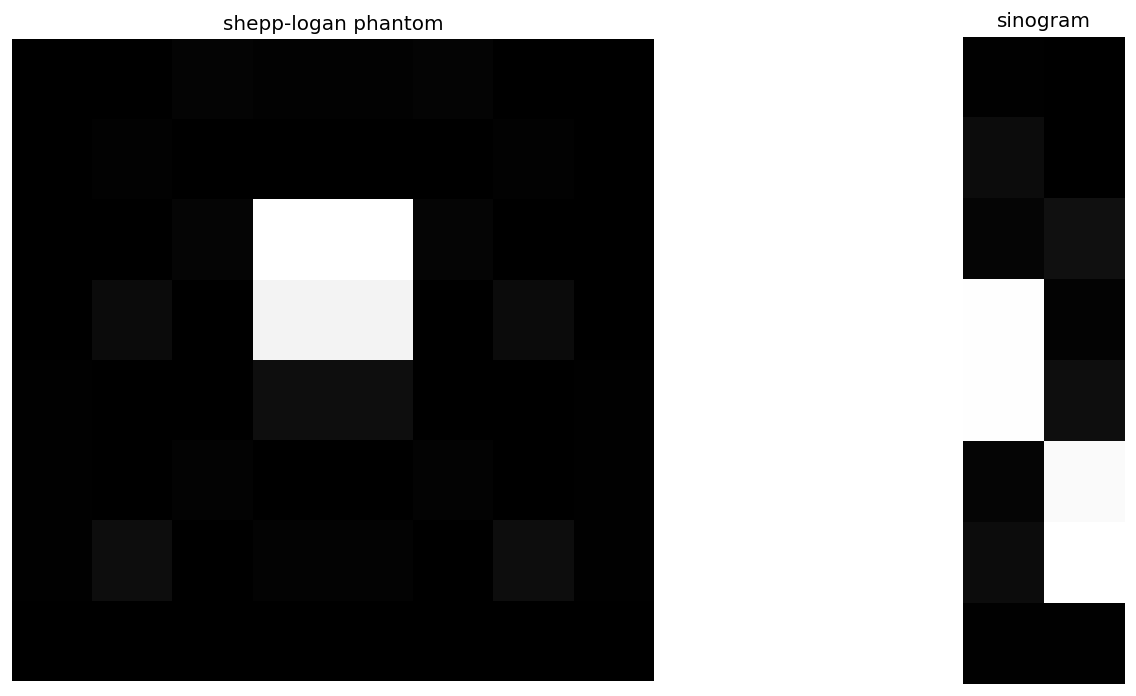

In [3]:
image = ski.io.imread(os.path.join("data", "8x8 square.jpg"))
# image = ski.color.rgb2gray(image)
image = ski.img_as_float(image)

# image = ski.data.shepp_logan_phantom()
# image = ski.transform.rescale(image, scale=0.01, mode='reflect', channel_axis=None)

# theta = np.linspace(0.0, 180.0, number_of_projections, endpoint=False)
theta = [0.0, 90.0]
sinogram = ski.transform.radon(image, theta=theta, circle=True)
print(f"{sinogram=}")

util.plot_images([image, sinogram], ['shepp-logan phantom', 'sinogram'])

sinogram_fake=array([[0.01176471, 0.04705882],
       [0.10196078, 0.01568627],
       [0.04705882, 2.03921569],
       [2.02745098, 1.99215686],
       [2.02745098, 0.11764706],
       [0.04705882, 0.03137255],
       [0.10196078, 0.13333333],
       [0.01176471, 0.        ]])


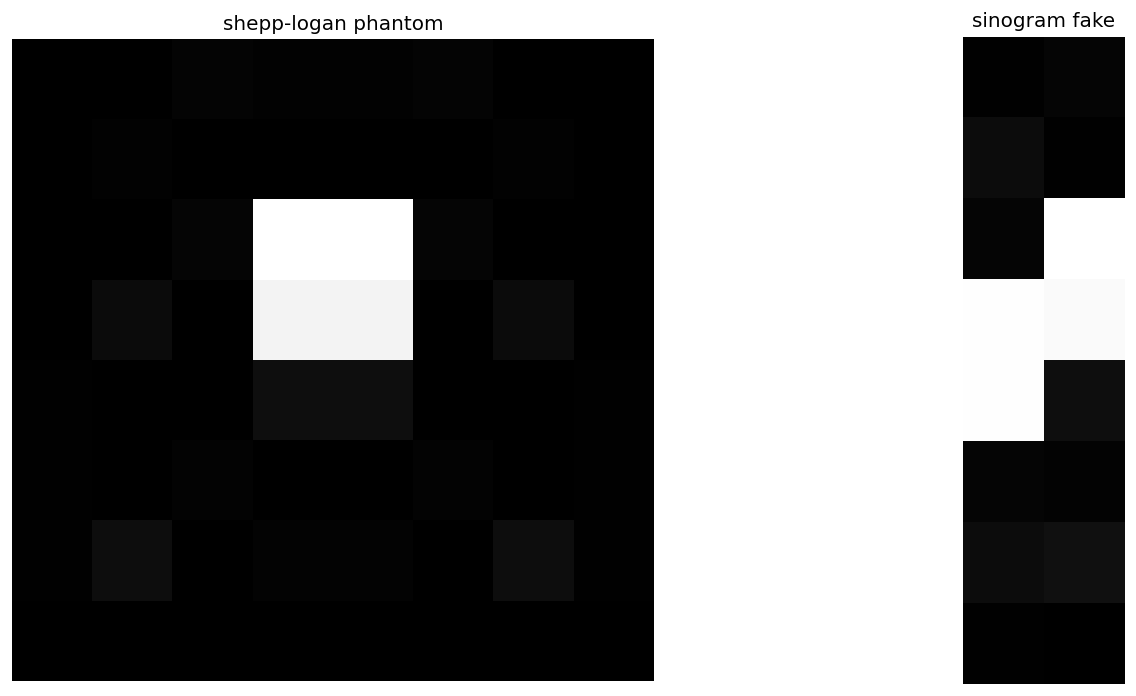

In [4]:
p0 = np.sum(image, axis=0)
p90 = np.sum(image, axis=1)
sinogram_fake = np.stack([p0, p90], 1)

print(f"{sinogram_fake=}")

util.plot_images([image, sinogram_fake], ['shepp-logan phantom', 'sinogram fake'])

In [5]:

print(f"{sinogram=}")
print(f"{sinogram_fake=}")

sinogram=array([[0.01176471, 0.        ],
       [0.10196078, 0.        ],
       [0.04705882, 0.13333333],
       [2.02745098, 0.03137255],
       [2.02745098, 0.11764706],
       [0.04705882, 1.99215686],
       [0.10196078, 2.03921569],
       [0.01176471, 0.01568627]])
sinogram_fake=array([[0.01176471, 0.04705882],
       [0.10196078, 0.01568627],
       [0.04705882, 2.03921569],
       [2.02745098, 1.99215686],
       [2.02745098, 0.11764706],
       [0.04705882, 0.03137255],
       [0.10196078, 0.13333333],
       [0.01176471, 0.        ]])


In [6]:
image_dim = image.shape[0]
image_dim2 = image.shape[0] ** 2 
# assume that image is square


# test that calculation is good

projection_resolution = image_dim

A_90 = np.zeros((image_dim, image_dim2))
ai90 = [] # cosmetic

for i in range(projection_resolution):
    Ai = np.zeros((image_dim, image_dim))
    Ai[i, :] = np.ones((image_dim))
    A_90 [i,:] = Ai.ravel()
    # print(Ai)
    ai90.append(Ai)

# A_90 = A_90.flatten()

A_0 = np.zeros((image_dim, image_dim2))
ai0 = [] # cosmetic

for i in range(projection_resolution):
    Ai = np.zeros((image_dim, image_dim))
    Ai[:, i] = np.ones((image_dim))
    A_0 [i,:] = Ai.ravel()
    ai0.append(Ai)
    # print(Ai)

# A_0 = A_0.flatten()

# show the A matrices in human viewable format
# util.plot_images(ai90, [str(x) + 'A90' for x in range(len(ai90))])
# util.plot_images(ai0, [str(x) + 'A0' for x in range(len(ai90))])

A = np.concat([A_0, A_90], axis=0)

b = sinogram_fake.flatten("F")
x = image.ravel()

res = A@x
# res_viewable = np.stack([res[0:4], res[4:]], axis=1) # cosmetic

cost1 = np.linalg.norm(res - b)

print(f"{image.shape=}")
print(f"{A.shape=}")
print(f"{b.shape=}")
print(f"{x.shape=}")
print(f"{res=} \n {res.shape=}")
print(f"{cost1=}")

image.shape=(8, 8)
A.shape=(16, 64)
b.shape=(16,)
x.shape=(64,)
res=array([0.01176471, 0.10196078, 0.04705882, 2.02745098, 2.02745098,
       0.04705882, 0.10196078, 0.01176471, 0.04705882, 0.01568627,
       2.03921569, 1.99215686, 0.11764706, 0.03137255, 0.13333333,
       0.        ]) 
 res.shape=(16,)
cost1=np.float64(0.0)


In [7]:
def _compute_spacial_lut(radius, sigma, print=False):
    x = np.arange(-radius, radius+1)
    X, Y = np.meshgrid(x, x)
    lut = np.exp(-(X**2 + Y**2)/(2*sigma**2))

    if print:
        fig =  plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(X, Y, lut, cmap='coolwarm')

    return lut



def compute_regularization_term(
    image : np.ndarray,
    sigma : float, # variance of gaussian used
    r     : int, # radius of window used, size of window is 2r+1 x 2r+1
):
    spacial_lut = _compute_spacial_lut(r, sigma)

    N = image.shape[0]
    if image.shape[1] != image.shape[0]:
        raise ValueError("image should be square")
        
    cumulative_error = 0

    for i in range(N):
        for j in range(N):
            left_ind = max(j - r, 0)
            right_ind = min(j + r + 1, N)
            up_ind = max(i - r, 0)
            down_ind = min(i + r + 1, N)

            left_lut = r - (j - left_ind)
            right_lut = left_lut + (right_ind - left_ind)
            up_lut = r - (i - up_ind)
            down_lut = up_lut + (down_ind - up_ind) 

            slice = image[up_ind:down_ind, left_ind:right_ind]
            slice = np.abs(slice - image[i,j])

            lut = spacial_lut[up_lut:down_lut, left_lut:right_lut]
            
            cumulative_error += np.sum(slice * lut)
            
    return cumulative_error


def cost(x, A, sinogram, gamma, sigma, r):
    img_two_d = np.reshape(x, (image_dim, image_dim))
    phi = compute_regularization_term(img_two_d, sigma, r)


    # stack the rows of the sinogram to form matrix b
    # order = 'F' means Fortran style indexing, so column-major
    b = sinogram.flatten(order='F')

    f = np.linalg.norm(A @ x - b) + gamma * phi
    return f

T0=np.float64(16.55502752764803)


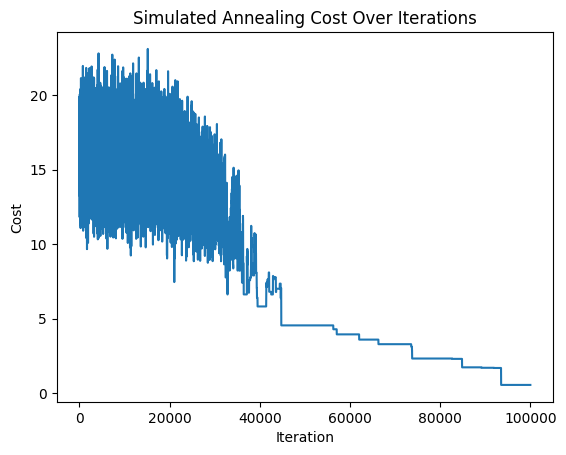

Best solution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Fitness: 0.5471188097508435


In [8]:
def neighbour(x, i, i_tot, h_min=1, h_max=None):
    """
    Generate a neighbour with Hamming distance h(i) that follows

        h(i) = ((h_min - h_max)/(i_tot-1)) * (i-1) + h_max

    Parameters
    ----------
    x : np.ndarray[int]
        Current binary vector.
    i : int
        Current iteration index (1-based, as on the slide).
    i_tot : int
        Total number of iterations.
    h_min : int, optional
        Minimum Hamming distance at the final iteration.
    h_max : int | None, optional
        Maximum Hamming distance at the first iteration.
        If None, defaults to ⌈0.1·n⌉  (10 % of the variables).

    Returns
    -------
    np.ndarray[int]
        New binary vector differing in h(i) positions.
    """
    n_bits = len(x)
    if h_max is None:
        h_max = max(1, int(np.ceil(0.10 * n_bits)))  # sensible default

    # ----- linear schedule from the slide ----
    h = ((h_min - h_max) / (i_tot - 1)) * (i - 1) + h_max
    h = int(round(h))                               # ensure integer
    h = max(h_min, min(h_max, h))                   # clamp to [h_min, h_max]
    # -----------------------------------------

    flip_idx = np.random.choice(n_bits, size=h, replace=False)
    x_new = x.copy()
    x_new[flip_idx] = 1 - x_new[flip_idx]           # bit-flip

    return x_new

# ---------- 3.  SIMULATED ANNEALING ----------
def simulated_annealing(x0, args=None, T0=10.0, alpha=0.99,
                        max_iter=1000, h_min=1, h_max=None):
    x, f = x0.copy(), cost(x0, *args)
    best_x, best_f = x.copy(), f
    T = T0
    costs = [f]

    for it in range(1, max_iter + 1):               # 1-based indexing
        x_new = neighbour(x, it, max_iter, h_min, h_max)
        f_new = cost(x_new, *args)
        delta = f_new - f

        # Metropolis criterion
        if delta < 0 or random.random() < math.exp(-delta / T) if T > 1e-10 else 1:
            x, f = x_new, f_new
            if f < best_f:
                best_x, best_f = x.copy(), f

        costs.append(f)
        T *= alpha                                  # geometric cooling

    # Plot the costs
    plt.figure()
    plt.plot(costs)
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    plt.title('Simulated Annealing Cost Over Iterations')
    plt.show()

    return best_x, best_f

def estimate_starting_temperature(n, A, b, gamma, sigma,r):
    costs = []
    for _ in range(n):
        x_rand = np.random.randint(0, 2, size=image_dim2)
        c = cost(x_rand, A, b, gamma, sigma,r)
        costs.append(c)
    return np.mean(costs)


# ---------- 4.  RUN IT ----------
initial_state = np.random.randint(0, 2, size=image_dim2)
gamma = 0.01
sigma = 1
r = 3

T0 = estimate_starting_temperature(1000, A, b, gamma, sigma, r)
print(f"{T0=}")

best_sol, best_val = simulated_annealing(
    initial_state,
    args=(A, sinogram_fake, gamma, sigma, r),
    max_iter=int(1e5),
    h_max=20,        # set to 5 as in the slide’s example
    h_min=1,
    T0=T0,
    alpha=0.9999
)

print("Best solution:", best_sol)
print("Fitness:", best_val)


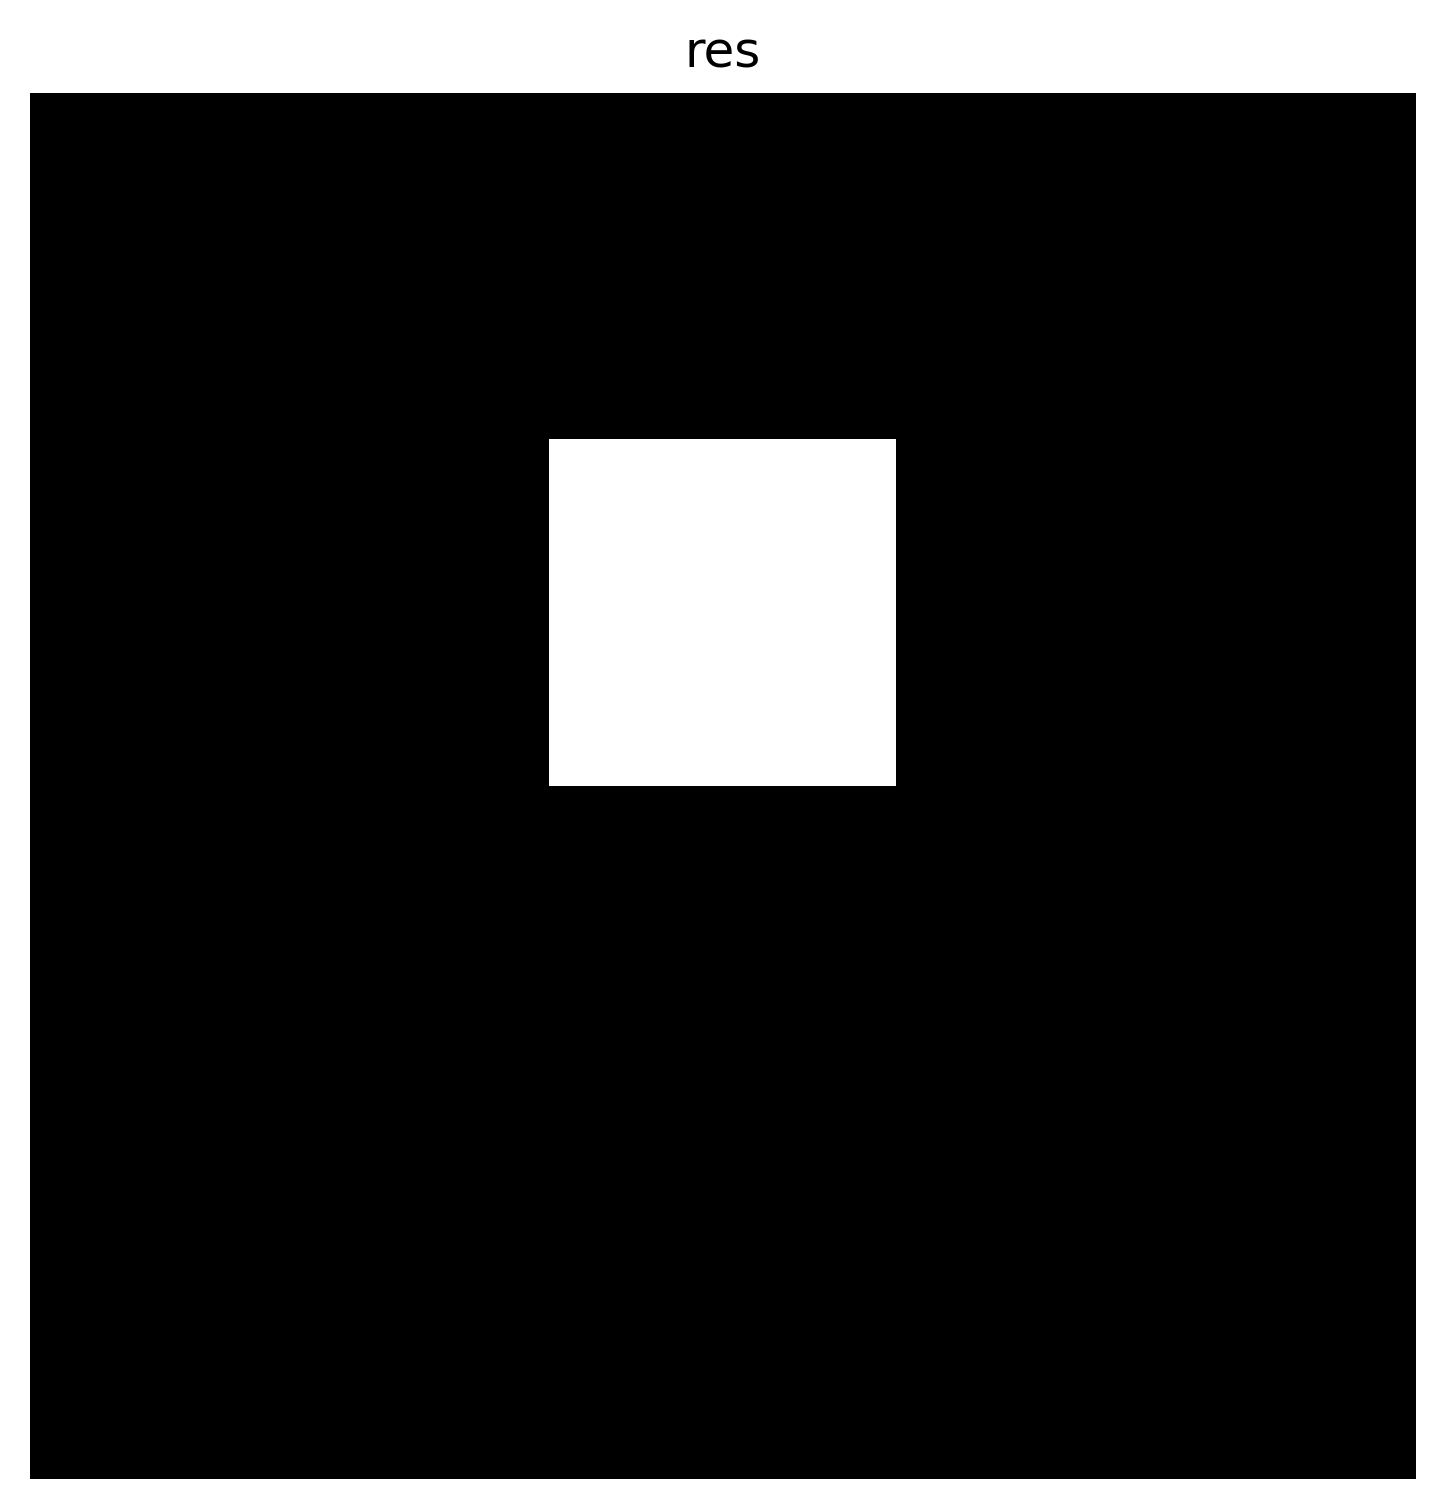

In [9]:
resulting_image = np.reshape(best_sol,(image_dim, image_dim))
util.plot_images([resulting_image], ['res'])

In [10]:
best_possible_cost = cost(image.ravel(), A, sinogram_fake, gamma, sigma, r)
print(best_possible_cost)

0.3187499634450756
